<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-2">Data preprocessing</a></span></li><li><span><a href="#Keras-model-creation-(vgg16)" data-toc-modified-id="Keras-model-creation-(vgg16)-3">Keras model creation (vgg16)</a></span><ul class="toc-item"><li><span><a href="#Gender-model" data-toc-modified-id="Gender-model-3.1">Gender model</a></span></li><li><span><a href="#Age-model" data-toc-modified-id="Age-model-3.2">Age model</a></span></li></ul></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-4">Заключение</a></span></li></ul></div>

# Imports

In [1]:
import os
from glob import glob
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras import utils
import keras_tuner

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from IPython.display import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Model

# Data preprocessing

In [2]:
# Путь к датасету UTKFace
data_path = 'UTKFace'

In [3]:
# Подготовка данных для создания DataFrame

ages = []
genders = []
# race = []
pixels = []
image_paths = []

miss_labels = 0

for img in tqdm(os.listdir(data_path)):
    splt = img.split('_')
    
    if len(splt) == 4:
        # Создание списка путей к изображениям
        image_path = data_path + '/' + img
        image_paths.append(image_path)
        
        # Создание списков меток
        age = splt[0]
        gender = splt[1]
#         race_ = splt[2]
        ages.append(int(age))
        genders.append(int(gender))
#         race.append(int(race_))
        
    else:
        # Счетчик изображений с пропущенными метками
        miss_labels += 1
print(f'количество изображений с пропущенными метками: {miss_labels}')

100%|████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 642127.36it/s]

количество изображений с пропущенными метками: 3


In [4]:
# Создание DataFrame с метками и преобразованными изображениями

df = pd.DataFrame()
df['ages'], df['genders'], df['image_paths'] = ages, genders, image_paths

In [5]:
# Создание словарей для кодирования меток

gender_dict = {0:'Male', 1:'Female'}
# race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Others'}

In [6]:
# удаление лиц с возрастом менее 2 и более 90 лет
df1 = df[(df['ages'] > 1) & (df['ages'] <= 90)].reset_index(drop=True)

# малый датафрем для отладки модели keras tuner только 3500 сэмплов
# df1 = df1.sample(n=3500, ignore_index=True) 

In [7]:
# предобработка изображений для обучения
x =[]

for image_path in tqdm(df1.image_paths):
    img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64,64))
    x.append((img))


100%|███████████████████████████████████████████████████████████████████████████| 22495/22495 [02:30<00:00, 149.29it/s]


In [8]:
x.shape

AttributeError: 'list' object has no attribute 'shape'

In [9]:
x = np.asarray(x, dtype=np.float32)
x = x.reshape(len(x), 64, 64, 3)

y = np.asarray([[gender, age] for i, gender, age, path in df1.itertuples()])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# labels for age model

y_age = y[:,0]

y_train_age = y_train[:,0]
y_test_age = y_test[:,0]
y_val_age = y_val[:,0]

# labels for gender model

y_gender = y[:,1]

y_train_gen = y_train[:,1]
y_test_gen = y_test[:,1]
y_val_gen = y_val[:,1]

print(f'AGE: x_train: {x_train.shape}, y_train_age: {y_train[:,0].shape}\n\
     x_val:    {x_val.shape}, y_val_age:    {y_val[:,0].shape}\n\
     x_test:   {x_test.shape}, y_test_age:   {y_test[:,0].shape}')
print('')
print(f'GENDER: x_train: {x_train.shape}, y_train_gender: {y_train[:,1].shape}\n\
        x_val:   {x_val.shape},  y_val_gender:    {y_val[:,1].shape}\n\
        x_test:  {x_test.shape},  y_test_gender:   {y_test[:,1].shape}')

AGE: x_train: (14396, 64, 64, 3), y_train_age: (14396,)
     x_val:    (3600, 64, 64, 3), y_val_age:    (3600,)
     x_test:   (4499, 64, 64, 3), y_test_age:   (4499,)

GENDER: x_train: (14396, 64, 64, 3), y_train_gender: (14396,)
        x_val:   (3600, 64, 64, 3),  y_val_gender:    (3600,)
        x_test:  (4499, 64, 64, 3),  y_test_gender:   (4499,)


# Keras model creation (vgg16)

## Gender model

In [11]:
# Загружаем сеть VGG16 без части, которая отвечает за классификацию
base_model = VGG16(weights='imagenet', include_top=False)

# Добавляем слои классификации
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Выходной слой с двумя нейронами для классов "M" и "F"
gender_out = Dense(2, activation='softmax')(x)


# Составляем сеть из двух частей
gen_model = Model(inputs=base_model.input, outputs=gender_out)

# "Замораживаем" сверточные уровни сети VGG16
# Обучаем только вновь добавленные слои
for layer in base_model.layers:
    layer.trainable = False

# Компилируем модель
gen_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [12]:
# Создаем генератор данных
batch_size = 64

y_train_gen = tf.keras.utils.to_categorical(y_train_gen, num_classes=2)
y_val_gen = tf.keras.utils.to_categorical(y_val_gen, num_classes=2)

datagen_gen = ImageDataGenerator(rescale=1./255.) 
train_gender = datagen_gen.flow(x_train, y_train_gen, batch_size=batch_size)

val_datagen_gender = ImageDataGenerator(rescale=1./255.)
val_gender = val_datagen_gender.flow(x_val, y_val_gen, batch_size=batch_size)


In [13]:
gen_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [14]:
epochs = 100
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)
                
model_path = 'vgg16_gender_model.h5'
checkpointer = ModelCheckpoint(model_path,
                               monitor = 'loss',
                               verbose = 1, 
                               save_best_only = True,
                               save_weights_only = False, 
                               mode = 'auto', save_freq = 'epoch')                

# tensorboard = TensorBoard(log_dir='tb_logs', histogram_freq=1, write_images=True)
callbacks_list = [checkpointer, earlystop]  #, tensorboard]

gen_model_history = gen_model.fit(train_gender, epochs=epochs, shuffle=True, validation_data=val_gender, callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6794
Epoch 1: loss improved from inf to 0.61508, saving model to vgg16_gender_model.h5
225/225 [==============================] - 232s 1s/step - loss: 0.6151 - accuracy: 0.6794 - val_loss: 0.5454 - val_accuracy: 0.7475
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.7605
Epoch 2: loss improved from 0.61508 to 0.52238, saving model to vgg16_gender_model.h5
225/225 [==============================] - 250s 1s/step - loss: 0.5224 - accuracy: 0.7605 - val_loss: 0.4921 - val_accuracy: 0.7833
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.7848
Epoch 3: loss improved from 0.52238 to 0.48268, saving model to vgg16_gender_model.h5
225/225 [==============================] - 252s 1s/step - loss: 0.4827 - accuracy: 0.7848 - val_loss: 0.4635 - val_accuracy: 0.7986
Epoch 4/100
225/225 [==============================] - ETA:

Epoch 27/100
225/225 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.8511
Epoch 27: loss improved from 0.34889 to 0.34529, saving model to vgg16_gender_model.h5
225/225 [==============================] - 243s 1s/step - loss: 0.3453 - accuracy: 0.8511 - val_loss: 0.3715 - val_accuracy: 0.8372
Epoch 28/100
225/225 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8524
Epoch 28: loss improved from 0.34529 to 0.34325, saving model to vgg16_gender_model.h5
225/225 [==============================] - 239s 1s/step - loss: 0.3432 - accuracy: 0.8524 - val_loss: 0.3708 - val_accuracy: 0.8375
Epoch 29/100
225/225 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8532
Epoch 29: loss improved from 0.34325 to 0.34182, saving model to vgg16_gender_model.h5
225/225 [==============================] - 226s 1s/step - loss: 0.3418 - accuracy: 0.8532 - val_loss: 0.3688 - val_accuracy: 0.8386
Epoch 30/100
225/225 [===========================

Epoch 53/100
225/225 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8742
Epoch 53: loss improved from 0.29925 to 0.29866, saving model to vgg16_gender_model.h5
225/225 [==============================] - 235s 1s/step - loss: 0.2987 - accuracy: 0.8742 - val_loss: 0.3565 - val_accuracy: 0.8431
Epoch 54/100
225/225 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.8764
Epoch 54: loss improved from 0.29866 to 0.29700, saving model to vgg16_gender_model.h5
225/225 [==============================] - 246s 1s/step - loss: 0.2970 - accuracy: 0.8764 - val_loss: 0.3557 - val_accuracy: 0.8453
Epoch 55/100
225/225 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8760
Epoch 55: loss improved from 0.29700 to 0.29597, saving model to vgg16_gender_model.h5
225/225 [==============================] - 244s 1s/step - loss: 0.2960 - accuracy: 0.8760 - val_loss: 0.3560 - val_accuracy: 0.8436
Epoch 56/100
225/225 [===========================

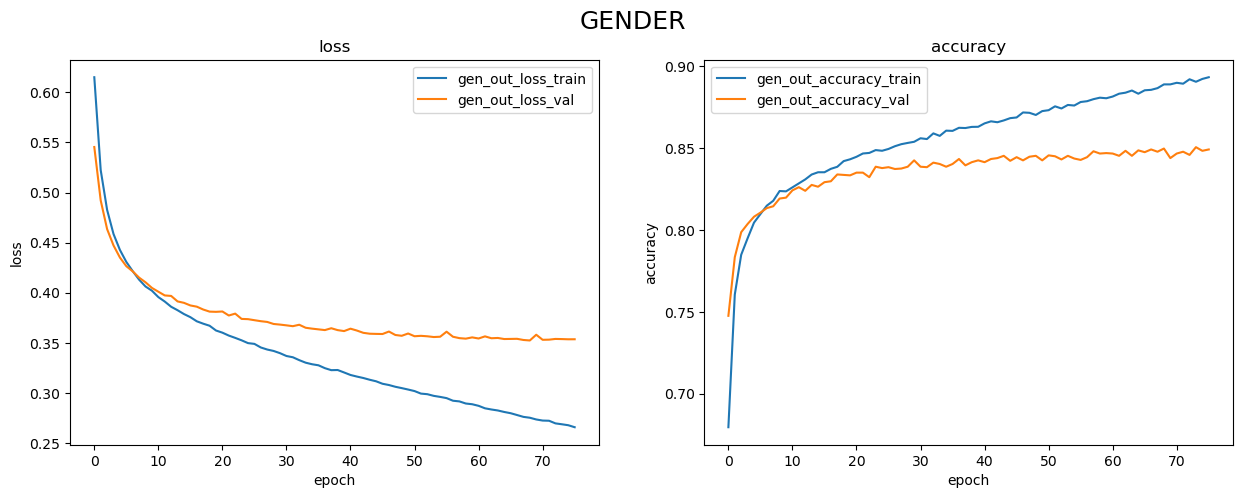

In [15]:
fig = plt.figure(figsize=(15, 5))

plt.suptitle('GENDER', fontsize=18)

# loss gender    
subplot = fig.add_subplot(1, 2, 1)
plt.plot(gen_model_history.history['loss'], label='gen_out_loss_train')
plt.plot(gen_model_history.history['val_loss'], label='gen_out_loss_val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('loss')

# mae gender
subplot = fig.add_subplot(1, 2, 2)
plt.plot(gen_model_history.history['accuracy'], label='gen_out_accuracy_train')
plt.plot(gen_model_history.history['val_accuracy'], label='gen_out_accuracy_val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('accuracy');

In [16]:
gen_model.evaluate(x_test/255, tf.keras.utils.to_categorical(y_test_gen, num_classes=2))

141/141 [==============================] - 48s 337ms/step - loss: 0.3430 - accuracy: 0.8491


[0.34302935004234314, 0.849077582359314]

In [17]:
def preprocess_and_predict(test_imgs, test_genders, n_samples=25):
    fig = plt.figure(figsize=(15, 12))
    for i in range(n_samples):
        img = test_imgs[i]
#         age = test_ages[i]
        gender = test_genders[i]
        
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img = cv2.resize(img, (64,64))
        
#         img = np.asarray(img)
        img = img/255
#         pred_age = age_model.predict(tf.expand_dims(img, axis=0))
        pred_gen = gen_model.predict(tf.expand_dims(img, axis=0))
        print(i, gender, pred_gen)
        subplot = fig.add_subplot(int(n_samples/5), 5, i+1)
        subplot.set_title(f'Gender_True: {gender} \n Gender_Pred: {np.round(np.argmax(pred_gen))}', fontsize=8)
        plt.axis('off')
        plt.imshow(img)
        
    return 

1/1 [==============================] - 1s 820ms/step
0 [0. 1.] [[0.00498529 0.9950147 ]]
1/1 [==============================] - 0s 35ms/step
1 [1. 0.] [[0.99315107 0.00684889]]
1/1 [==============================] - 0s 34ms/step
2 [0. 1.] [[0.11766778 0.88233227]]
1/1 [==============================] - 0s 35ms/step
3 [1. 0.] [[0.5067836  0.49321634]]
1/1 [==============================] - 0s 36ms/step
4 [1. 0.] [[0.9607134 0.0392866]]
1/1 [==============================] - 0s 38ms/step
5 [1. 0.] [[9.9975294e-01 2.4705214e-04]]
1/1 [==============================] - 0s 33ms/step
6 [1. 0.] [[9.9999857e-01 1.4437888e-06]]
1/1 [==============================] - 0s 35ms/step
7 [0. 1.] [[5.4319855e-04 9.9945682e-01]]
1/1 [==============================] - 0s 36ms/step
8 [1. 0.] [[0.04622538 0.95377463]]
1/1 [==============================] - 0s 36ms/step
9 [0. 1.] [[0.00723445 0.99276555]]
1/1 [==============================] - 0s 34ms/step
10 [0. 1.] [[0.94331515 0.0566849 ]]
1/1 [=========

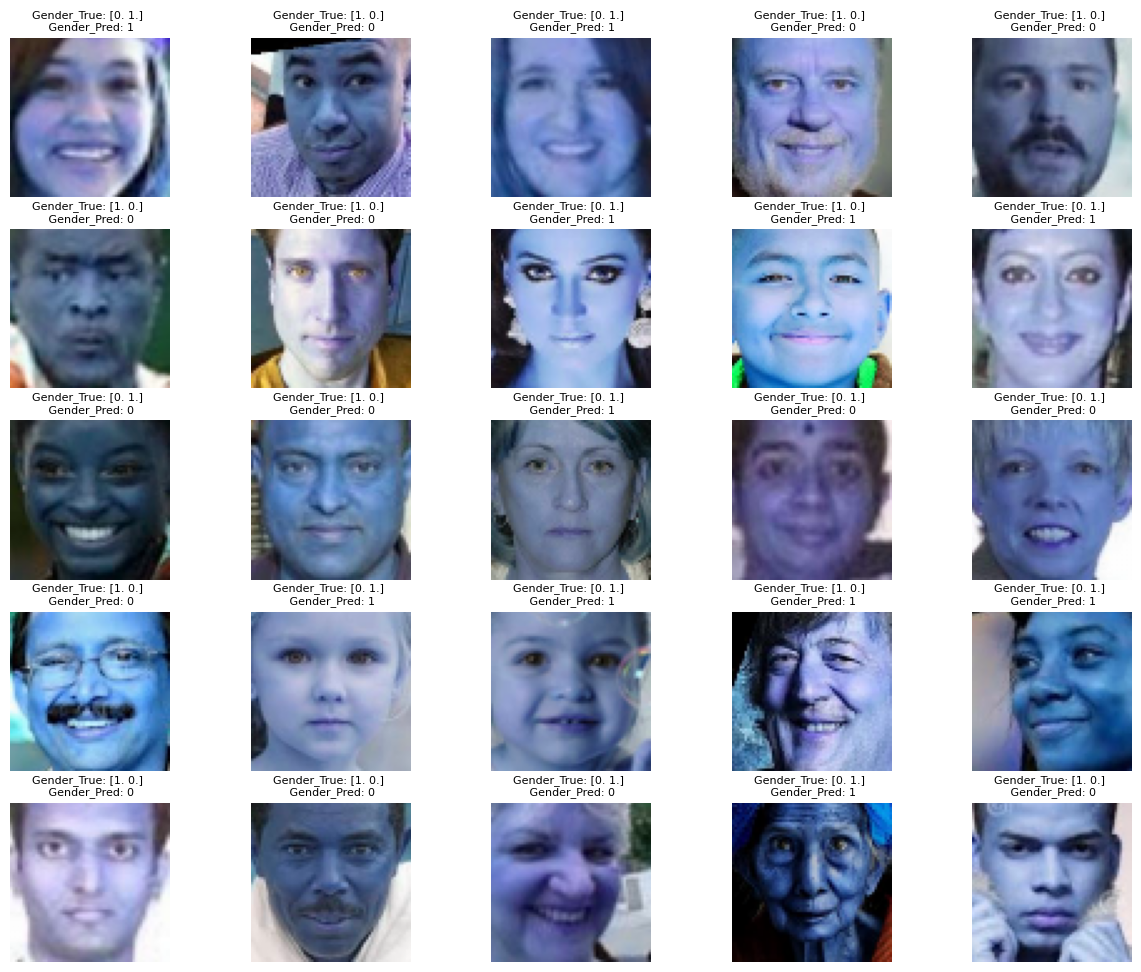

In [18]:
preprocess_and_predict(x_test[:25], tf.keras.utils.to_categorical(y_test_gen, num_classes=2)[:25])

## Age model

In [19]:
# Загружаем сеть VGG16 без части, которая отвечает за классификацию
base_model = VGG16(weights='imagenet', include_top=False)

# Добавляем слои классификации
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Выходной слой с двумя нейронами для классов "M" и "F"
age_aut = Dense(1, activation='relu')(x)

# Составляем сеть из двух частей
age_model = Model(inputs=base_model.input, outputs=age_aut)

# "Замораживаем" сверточные уровни сети VGG16
# Обучаем только вновь добавленные слои
for layer in base_model.layers:
    layer.trainable = False

# Компилируем модель
age_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

In [20]:
# Создаем генератор данных
batch_size = 64


datagen_age = ImageDataGenerator(rescale=1./255.)
train_age = datagen_age.flow(x_train, y_train_age, batch_size=batch_size)

val_datagen_age = ImageDataGenerator(rescale=1./255.)
val_age = val_datagen_age.flow(x_val, y_val_age, batch_size=batch_size)


In [21]:
age_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [22]:
epochs = 100
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)
                
model_path = 'vgg16_age_model.h5'
checkpointer = ModelCheckpoint(model_path,
                               monitor = 'loss',
                               verbose = 1, 
                               save_best_only = True,
                               save_weights_only = False, 
                               mode = 'auto', save_freq = 'epoch')                

# tensorboard = TensorBoard(log_dir='tb_logs', histogram_freq=1, write_images=True)
callbacks_list = [checkpointer, earlystop]  #, tensorboard]

age_model_history = age_model.fit(train_age, epochs=epochs, shuffle=True, validation_data=val_age, callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 363.9542 - mae: 14.5768
Epoch 1: loss improved from inf to 363.95416, saving model to vgg16_age_model.h5
225/225 [==============================] - 209s 925ms/step - loss: 363.9542 - mae: 14.5768 - val_loss: 240.0775 - val_mae: 12.0584
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 218.9156 - mae: 11.4976
Epoch 2: loss improved from 363.95416 to 218.91559, saving model to vgg16_age_model.h5
225/225 [==============================] - 224s 997ms/step - loss: 218.9156 - mae: 11.4976 - val_loss: 204.7576 - val_mae: 11.0939
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 199.4574 - mae: 10.9017
Epoch 3: loss improved from 218.91559 to 199.45740, saving model to vgg16_age_model.h5
225/225 [==============================] - 236s 1s/step - loss: 199.4574 - mae: 10.9017 - val_loss: 198.8914 - val_mae: 11.0788
Epoch 4/100
225/225 [==============================] - ETA: 0s - loss:

225/225 [==============================] - 237s 1s/step - loss: 144.2457 - mae: 9.0251 - val_loss: 157.6402 - val_mae: 9.3131
Epoch 28/100
225/225 [==============================] - ETA: 0s - loss: 144.0390 - mae: 9.0052
Epoch 28: loss improved from 144.24573 to 144.03897, saving model to vgg16_age_model.h5
225/225 [==============================] - 236s 1s/step - loss: 144.0390 - mae: 9.0052 - val_loss: 162.7431 - val_mae: 9.8095
Epoch 29/100
225/225 [==============================] - ETA: 0s - loss: 142.4499 - mae: 8.9571
Epoch 29: loss improved from 144.03897 to 142.44986, saving model to vgg16_age_model.h5
225/225 [==============================] - 236s 1s/step - loss: 142.4499 - mae: 8.9571 - val_loss: 155.9172 - val_mae: 9.4112
Epoch 30/100
225/225 [==============================] - ETA: 0s - loss: 141.3355 - mae: 8.9200
Epoch 30: loss improved from 142.44986 to 141.33553, saving model to vgg16_age_model.h5
225/225 [==============================] - 235s 1s/step - loss: 141.3355 

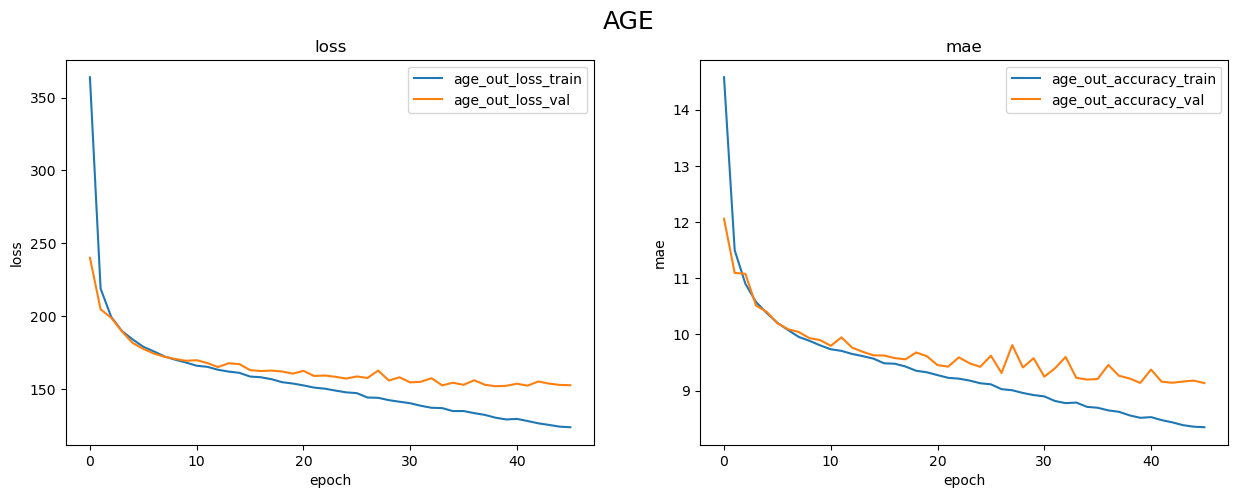

In [23]:
fig = plt.figure(figsize=(15, 5))

plt.suptitle('AGE', fontsize=18)

# loss gender    
subplot = fig.add_subplot(1, 2, 1)
plt.plot(age_model_history.history['loss'], label='age_out_loss_train')
plt.plot(age_model_history.history['val_loss'], label='age_out_loss_val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('loss')

# mae gender
subplot = fig.add_subplot(1, 2, 2)
plt.plot(age_model_history.history['mae'], label='age_out_accuracy_train')
plt.plot(age_model_history.history['val_mae'], label='age_out_accuracy_val')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()
plt.title('mae');

In [24]:
age_model.evaluate(x_test/255, y_test_age)

141/141 [==============================] - 48s 341ms/step - loss: 147.3765 - mae: 9.0244


[147.37652587890625, 9.024441719055176]

In [25]:
def preprocess_and_predict(test_imgs, test_age, n_samples=25):
    fig = plt.figure(figsize=(15, 12))
    for i in range(n_samples):
        img = test_imgs[i]
        age = test_age[i]
#         gender = test_genders[i]
        
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img = cv2.resize(img, (64,64))
        
#         img = np.asarray(img)
        img = img/255
        pred_age = age_model.predict(tf.expand_dims(img, axis=0))
#         pred_gen = gen_model.predict(tf.expand_dims(img, axis=0))
        print(i, age, np.round(pred_age[0][0]), age-np.round(pred_age[0][0]))
        subplot = fig.add_subplot(int(n_samples/5), 5, i+1)
        subplot.set_title(f'Gender_True: {age} \n Gender_Pred: {np.around(pred_age)}', fontsize=8)
        plt.axis('off')
        plt.imshow(img)
        
    return 

1/1 [==============================] - 0s 381ms/step
0 24 35.0 -11.0
1/1 [==============================] - 0s 36ms/step
1 26 23.0 3.0
1/1 [==============================] - 0s 36ms/step
2 29 35.0 -6.0
1/1 [==============================] - 0s 36ms/step
3 56 46.0 10.0
1/1 [==============================] - 0s 35ms/step
4 37 43.0 -6.0
1/1 [==============================] - 0s 43ms/step
5 54 44.0 10.0
1/1 [==============================] - 0s 36ms/step
6 39 38.0 1.0
1/1 [==============================] - 0s 34ms/step
7 21 34.0 -13.0
1/1 [==============================] - 0s 35ms/step
8 12 7.0 5.0
1/1 [==============================] - 0s 38ms/step
9 45 33.0 12.0
1/1 [==============================] - 0s 35ms/step
10 26 38.0 -12.0
1/1 [==============================] - 0s 42ms/step
11 47 39.0 8.0
1/1 [==============================] - 0s 42ms/step
12 58 29.0 29.0
1/1 [==============================] - 0s 42ms/step
13 56 41.0 15.0
1/1 [==============================] - 0s 36ms/step
14 45 1

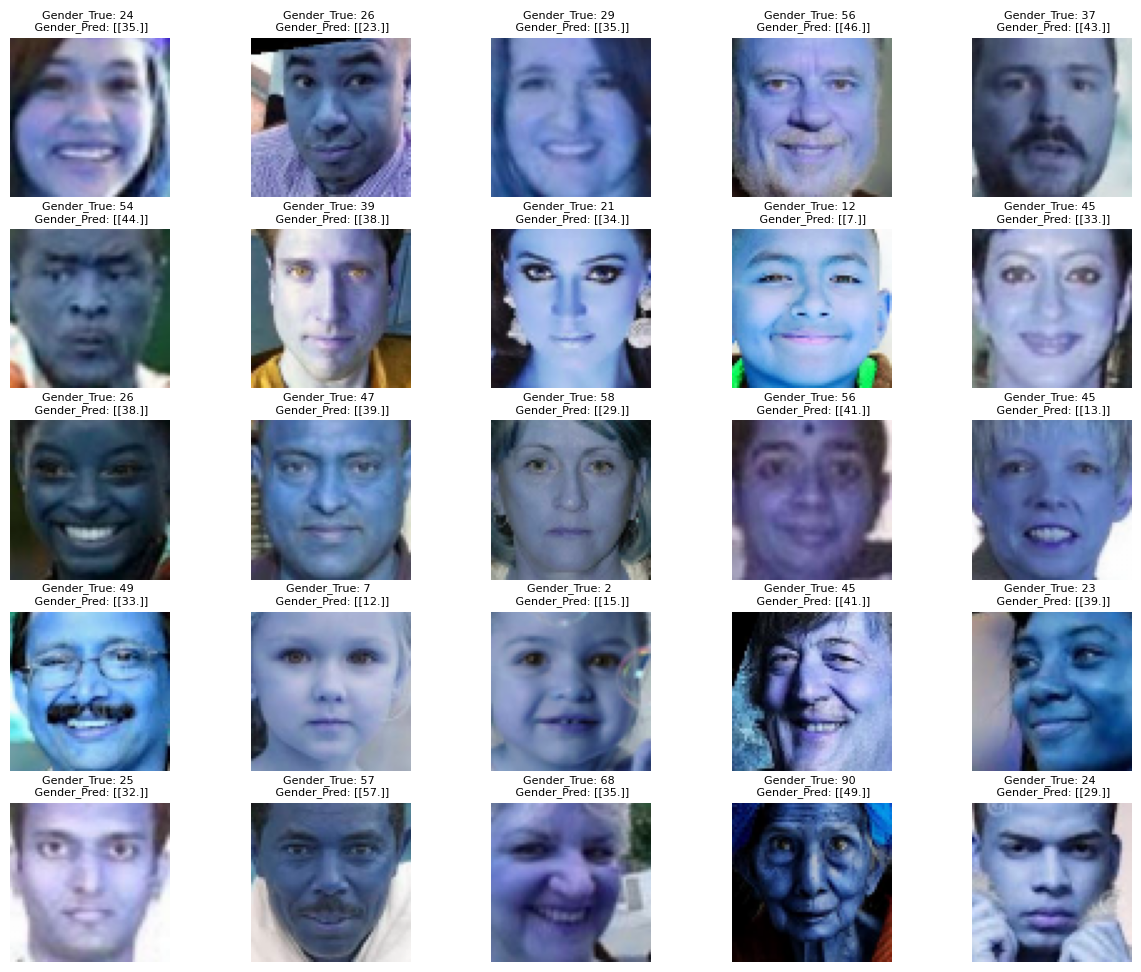

In [26]:
preprocess_and_predict(x_test[:25], y_test_age[:25])

# Заключение

Результаты на тестовых данных:

age_model: loss: 147.3765 - mae: 9.0244

gen_model: loss: 0.3430 - accuracy: 0.8491